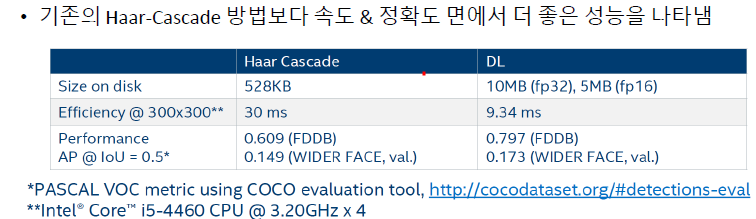

### SSD : single shot multibox detector
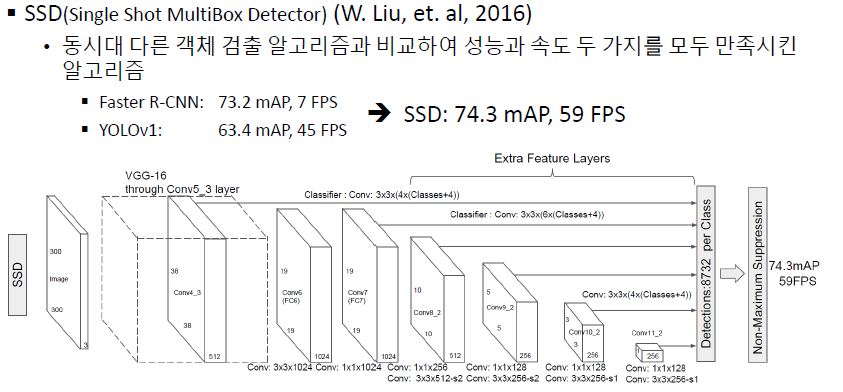

#### parameters
 - size : 300X300
 - scale: 1(0~255)
 - Mean : (104,177,123)
 - RGB  : False
 
 - out.shape: (1,1,200,7) 
 - detect   : [0,0,:,:]
   - 마지막 7에 해당하는 부분 -> 0,1,c,x1,y1,x2,y2 
 

In [2]:
import sys
import numpy as np
import cv2


model = '.\\ch13\\opencv_face_detector\\res10_300x300_ssd_iter_140000_fp16.caffemodel'
config = '.\\ch13\\opencv_face_detector\\deploy.prototxt'
#model = 'opencv_face_detector/opencv_face_detector_uint8.pb'
#config = 'opencv_face_detector/opencv_face_detector.pbtxt'

cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print('Camera open failed!')
    sys.exit()

net = cv2.dnn.readNet(model, config)

if net.empty():
    print('Net open failed!')
    sys.exit()

while True:
    ret, frame = cap.read()

    if not ret:
        break

    blob = cv2.dnn.blobFromImage(frame, 1, (300, 300), (104, 177, 123))
    net.setInput(blob)
    out = net.forward()

    detect = out[0, 0, :, :]
    (h, w) = frame.shape[:2]

    for i in range(detect.shape[0]):
        confidence = detect[i, 2]
        if confidence < 0.5:
            break

        x1 = int(detect[i, 3] * w)
        y1 = int(detect[i, 4] * h)
        x2 = int(detect[i, 5] * w)
        y2 = int(detect[i, 6] * h)

        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0))

        label = f'Face: {confidence:4.2f}'
        cv2.putText(frame, label, (x1, y1 - 1), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 1, cv2.LINE_AA)

    cv2.imshow('frame', frame)

    if cv2.waitKey(1) == 27:
        break

cv2.destroyAllWindows()


### YOLO : you only look once
 - darknet : [https://pjreddie.com/darknet/yolo/]
 - Tech Report : [https://arxiv.org/abs/1804.02767]
 - coco dataset : [https://cocodataset.org/#home]
 
#### parameters 
 - size : (320,320) ,(416,416), (608,608)
 - scale: 1/255. (0.00392)
 - Mean : (0,0,0)
 - RGB  : True
 
 - out[0].shape: 507*85 = (13 *13 *3) *(4+1+80)
 - out[1].shape: 2028*85 = (26 *26 *3) *(4+1+80)
 - out[2].shape: 8112*85 = (52 *52 *3) *(4+1+80)

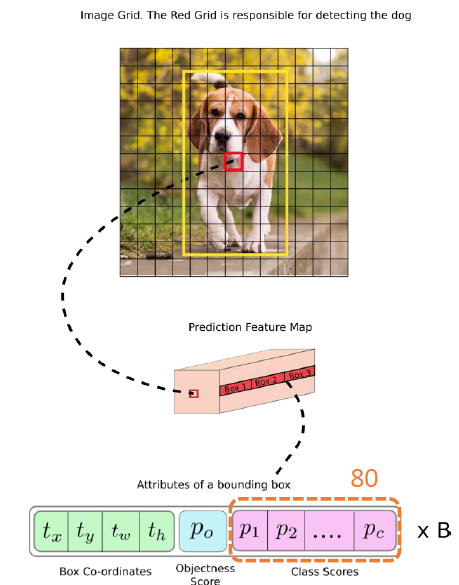

#### files 
 - model file : 

In [5]:
import sys
import numpy as np
import cv2


# 모델 & 설정 파일
model = '.\\ch13\\yolo_v3\\yolov3.weights'
config = '.\\ch13\\yolo_v3\\yolov3.cfg'
class_labels = '.\\ch13\\yolo_v3\\coco.names'
confThreshold = 0.5
nmsThreshold = 0.4

# 테스트 이미지 파일
img_files = ['dog.jpg', 'person.jpg', 'sheep.jpg', 'kite.jpg']

# 네트워크 생성
net = cv2.dnn.readNet(model, config)

if net.empty():
    print('Net open failed!')
    sys.exit()

# 클래스 이름 불러오기

classes = []
with open(class_labels, 'rt') as f:
    classes = f.read().rstrip('\n').split('\n')

colors = np.random.uniform(0, 255, size=(len(classes), 3))

# 출력 레이어 이름 받아오기

layer_names = net.getLayerNames()
# output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
output_layers = ['yolo_82', 'yolo_94', 'yolo_106']

# 실행

for f in img_files:
    f= '.\\ch13\\'+f
    img = cv2.imread(f)

    if img is None:
        continue

    # 블롭 생성 & 추론
    blob = cv2.dnn.blobFromImage(img, 1/255., (320, 320), swapRB=True)
    net.setInput(blob)
    outs = net.forward(output_layers)

    # outs는 3개의 ndarray 리스트.
    # outs[0].shape=(507, 85), 13*13*3=507
    # outs[1].shape=(2028, 85), 26*26*3=2028
    # outs[2].shape=(8112, 85), 52*52*3=8112

    h, w = img.shape[:2]

    class_ids = []
    confidences = []
    boxes = []

    for out in outs:
        for detection in out:
            # detection: 4(bounding box) + 1(objectness_score) + 80(class confidence)
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > confThreshold:
                # 바운딩 박스 중심 좌표 & 박스 크기
                cx = int(detection[0] * w)
                cy = int(detection[1] * h)
                bw = int(detection[2] * w)
                bh = int(detection[3] * h)

                # 바운딩 박스 좌상단 좌표
                sx = int(cx - bw / 2)
                sy = int(cy - bh / 2)

                boxes.append([sx, sy, bw, bh])
                confidences.append(float(confidence))
                class_ids.append(int(class_id))

    # 비최대 억제
    indices = cv2.dnn.NMSBoxes(boxes, confidences, confThreshold, nmsThreshold)
    print(indices.shape)
    for i in indices:
#         i = i[0]
        sx, sy, bw, bh = boxes[i]
        label = f'{classes[class_ids[i]]}: {confidences[i]:.2}'
        color = colors[class_ids[i]]
        cv2.rectangle(img, (sx, sy, bw, bh), color, 2)
        cv2.putText(img, label, (sx, sy - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2, cv2.LINE_AA)

    t, _ = net.getPerfProfile()
    label = 'Inference time: %.2f ms' % (t * 1000.0 / cv2.getTickFrequency())
    cv2.putText(img, label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX,
                0.7, (0, 0, 255), 1, cv2.LINE_AA)

    cv2.imshow('img', img)
    cv2.waitKey()

cv2.destroyAllWindows()


(3,)
(3,)
(2,)
(16,)
